## Detect Cycle start and end

In [ ]:
from pathlib import Path

VIDEO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0038.MP4")
ANNO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations\DJI_0038_annotations.json")

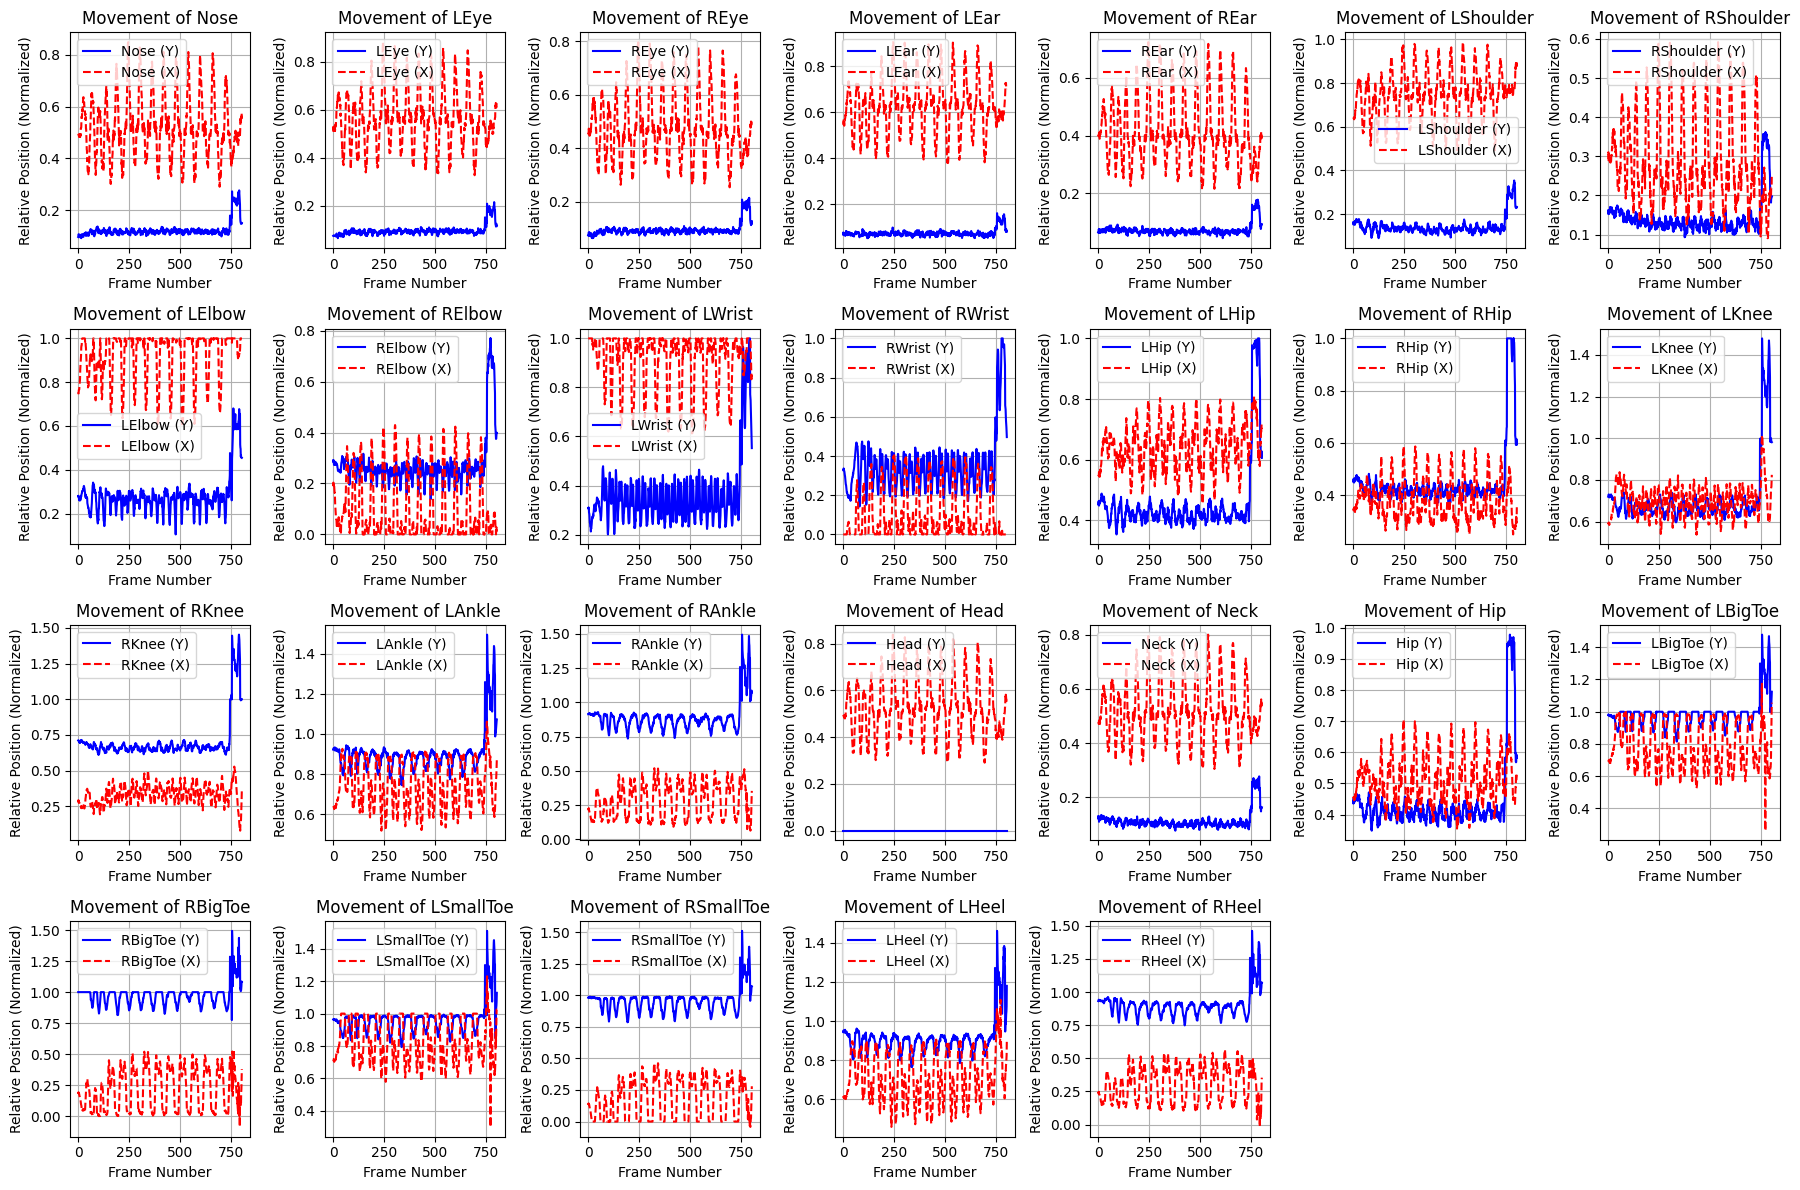

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


with open(ANNO_PATH, "r") as f:
    data = json.load(f)

# Extract keypoint names from "categories"
keypoint_names = data["categories"][0]["keypoints"]
num_keypoints = len(keypoint_names)

# Dictionary to store keypoint trajectories
keypoint_trajectories = {name: {"x": [], "y": [], "frames": []} for name in keypoint_names}

# Extract keypoints over time and normalize by bounding box
for annotation in data["annotations"]:
    frame_id = annotation["image_id"]
    keypoints = annotation["keypoints"]  # List of [x, y, confidence] values
    bbox = annotation["bbox"]  # Bounding box: [x, y, width, height]

    bbox_x, bbox_y, bbox_w, bbox_h = bbox  # Extract bounding box coordinates

    for i in range(num_keypoints):
        x, y, confidence = keypoints[i * 3: i * 3 + 3]

        # Normalize by bounding box dimensions
        norm_x = (x - bbox_x) / bbox_w
        norm_y = (y - bbox_y) / bbox_h

        keypoint_trajectories[keypoint_names[i]]["x"].append(norm_x)
        keypoint_trajectories[keypoint_names[i]]["y"].append(norm_y)
        keypoint_trajectories[keypoint_names[i]]["frames"].append(frame_id)

# Plot keypoint movement over time
fig, axes = plt.subplots(nrows=4, ncols=(num_keypoints + 3) // 4, figsize=(18, 12))  # Bigger plot size
axes = axes.flatten()

for i, keypoint in enumerate(keypoint_names):
    ax = axes[i]
    ax.plot(keypoint_trajectories[keypoint]["frames"], keypoint_trajectories[keypoint]["y"], label=f"{keypoint} (Y)", color="b")
    ax.plot(keypoint_trajectories[keypoint]["frames"], keypoint_trajectories[keypoint]["x"], label=f"{keypoint} (X)", color="r", linestyle="dashed")
    ax.set_title(f"Movement of {keypoint}")
    ax.set_xlabel("Frame Number")
    ax.set_ylabel("Relative Position (Normalized)")
    ax.legend()
    ax.grid(True)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


c:\Users\britt\anaconda3\envs\alphapose\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


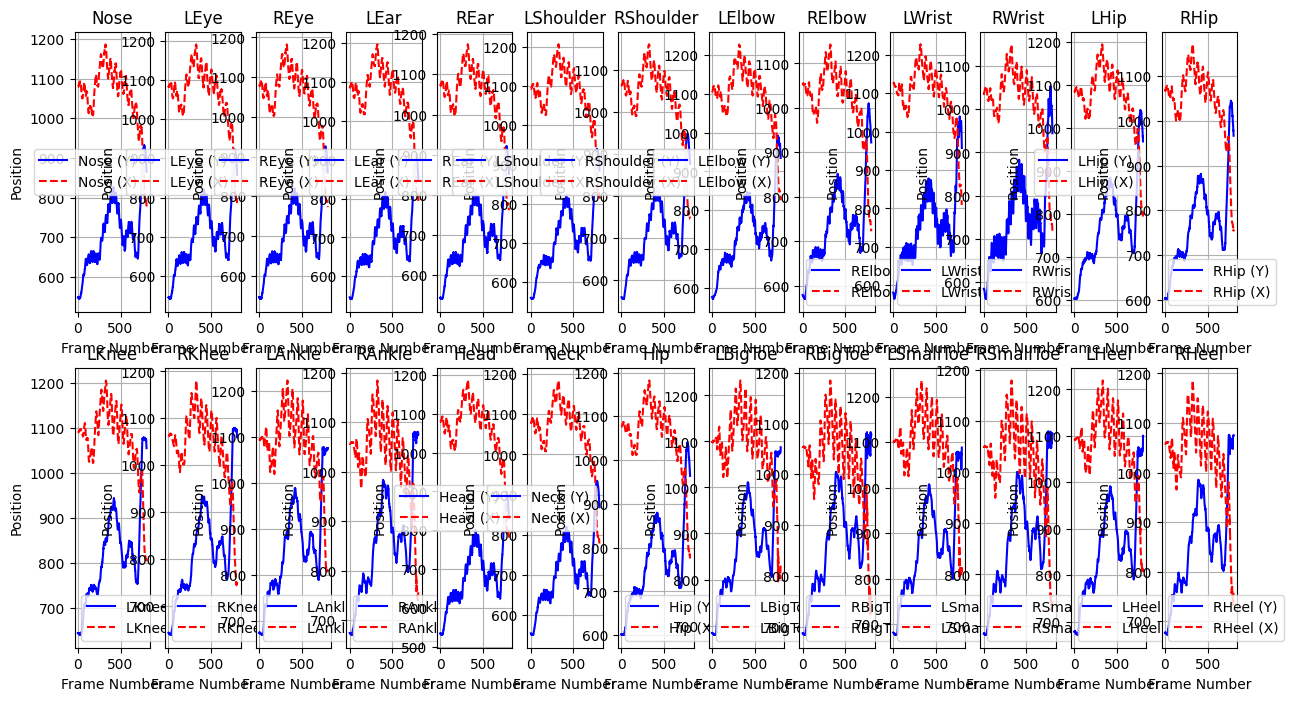

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


with open(ANNO_PATH, "r") as f:
    data = json.load(f)

# Extract keypoint names from "categories"
keypoint_names = data["categories"][0]["keypoints"]
num_keypoints = len(keypoint_names)

# Dictionary to store keypoint trajectories
keypoint_trajectories = {name: {"x": [], "y": [], "frames": []} for name in keypoint_names}

# Extract keypoints over time
for annotation in data["annotations"]:
    frame_id = annotation["image_id"]
    keypoints = annotation["keypoints"]  # List of [x, y, confidence] values

    for i in range(num_keypoints):
        x, y, confidence = keypoints[i * 3: i * 3 + 3]
        keypoint_trajectories[keypoint_names[i]]["x"].append(x)
        keypoint_trajectories[keypoint_names[i]]["y"].append(y)
        keypoint_trajectories[keypoint_names[i]]["frames"].append(frame_id)

# Plot keypoint movement over time
fig, axes = plt.subplots(nrows=2, ncols=(num_keypoints + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, keypoint in enumerate(keypoint_names):
    ax = axes[i]
    ax.plot(keypoint_trajectories[keypoint]["frames"], keypoint_trajectories[keypoint]["y"], label=f"{keypoint} (Y)", color="b")
    ax.plot(keypoint_trajectories[keypoint]["frames"], keypoint_trajectories[keypoint]["x"], label=f"{keypoint} (X)", color="r", linestyle="dashed")
    ax.set_title(keypoint)
    ax.set_xlabel("Frame Number")
    ax.set_ylabel("Position")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


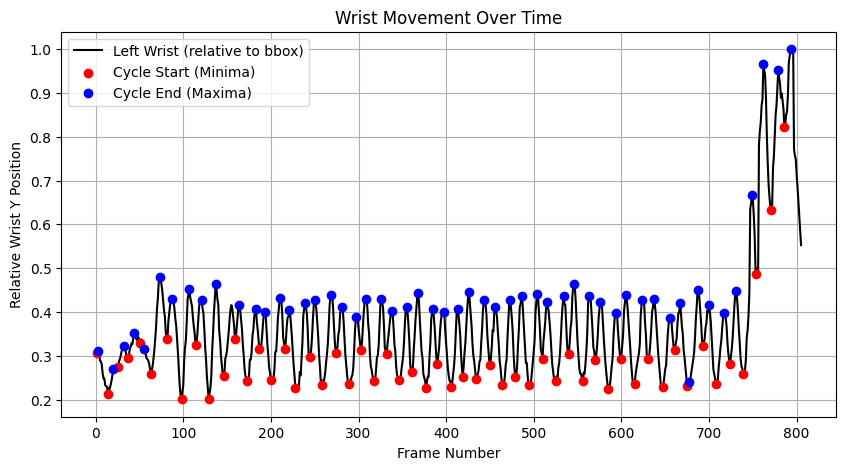

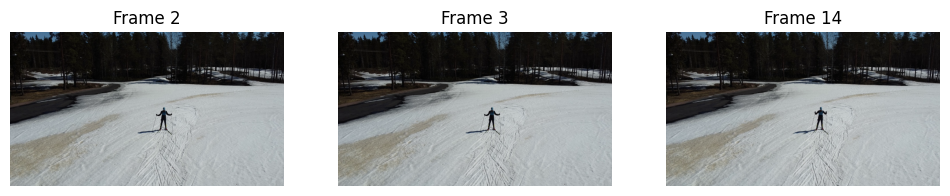

Saved detected cycle frames to detected_cycles.json
Saved cycle 1 as cycle_example_1.gif
Saved cycle 2 as cycle_example_2.gif
Saved cycle 3 as cycle_example_3.gif
Saved cycle 4 as cycle_example_4.gif
Saved cycle 5 as cycle_example_5.gif
Saved cycle 6 as cycle_example_6.gif


In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import find_peaks
from pathlib import Path
from PIL import Image
import imageio

# Use provided paths
ANNO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations\DJI_0038_annotations.json")
VIDEO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0038.MP4")

# Load keypoint annotations
with open(ANNO_PATH, "r") as f:
    data = json.load(f)

# Extract keypoint indices
keypoints_list = data["categories"][0]["keypoints"]
LWrist_index = keypoints_list.index("LWrist") * 3
RWrist_index = keypoints_list.index("RWrist") * 3

# Store wrist positions, bounding box data, and frames
frames = []
lwrist_y = []
rwrist_y = []
bounding_boxes = []

for annotation in data.get("annotations", []):
    frame_id = annotation["image_id"]
    keypoints = annotation["keypoints"]
    bbox = annotation["bbox"]  # Bounding box: [x, y, width, height]

    # Extract wrist Y-coordinates relative to bounding box
    if bbox:
        x, y, w, h = bbox
        lwrist_y.append((keypoints[LWrist_index + 1] - y) / h)  # Normalize within bounding box
        rwrist_y.append((keypoints[RWrist_index + 1] - y) / h)

        frames.append(frame_id)
        bounding_boxes.append(bbox)

# Convert to numpy
frames = np.array(frames)
lwrist_y = np.array(lwrist_y)
rwrist_y = np.array(rwrist_y)

# Detect cycles using wrist movement (minima detection)
min_peaks_L, _ = find_peaks(-lwrist_y, distance=10)  # Find cycle start (low points)
max_peaks_L, _ = find_peaks(lwrist_y, distance=10)   # Find cycle end (high points)

# Save all detected cycle frame numbers
cycle_frames = [(frames[min_peaks_L[i]], frames[min_peaks_L[i + 1]]) for i in range(len(min_peaks_L) - 1)]

# Plot wrist movement over time with cycle markers
plt.figure(figsize=(10, 5))
plt.plot(frames, lwrist_y, "k", marker="", linestyle="-", label="Left Wrist (relative to bbox)")
plt.scatter(frames[min_peaks_L], lwrist_y[min_peaks_L], color="red", label="Cycle Start (Minima)", zorder=3)
plt.scatter(frames[max_peaks_L], lwrist_y[max_peaks_L], color="blue", label="Cycle End (Maxima)", zorder=3)
plt.xlabel("Frame Number")
plt.ylabel("Relative Wrist Y Position")
plt.title("Wrist Movement Over Time")
plt.legend()
plt.grid(True)

# Show 3 images at cycle start, end, and next start
cap = cv2.VideoCapture(str(VIDEO_PATH))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, frame_id in enumerate([frames[min_peaks_L[0]], frames[max_peaks_L[0]], frames[min_peaks_L[1]]]):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB for PIL
        axes[i].imshow(frame)
        axes[i].axis("off")
        axes[i].set_title(f"Frame {frame_id}")

cap.release()
plt.show()

# Save detected cycles to a JSON file
with open("detected_cycles.json", "w") as f:
    json.dump([(int(start), int(end)) for start, end in cycle_frames], f, indent=4)

print(f"Saved detected cycle frames to detected_cycles.json")

# Generate short sequences for 2 example cycles
example_cycles = cycle_frames[2:8]  # First two cycles
cap = cv2.VideoCapture(str(VIDEO_PATH))

for i, (start, end) in enumerate(example_cycles):
    images = []  # Reset image list for each cycle
    
    for frame_id in range(start, end + 1):  # Include all frames in the cycle
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            images.append(Image.fromarray(frame))

    # Save each cycle as a separate GIF
    gif_filename = f"cycle_example_{i+1}.gif"
    imageio.mimsave(gif_filename, images, duration=0.05)  # Adjust duration for smooth playback
    print(f"Saved cycle {i+1} as {gif_filename}")

cap.release()


In [13]:
print(example_cycles)

[(26, 37), (37, 51), (51, 63), (63, 81), (81, 98), (98, 114)]


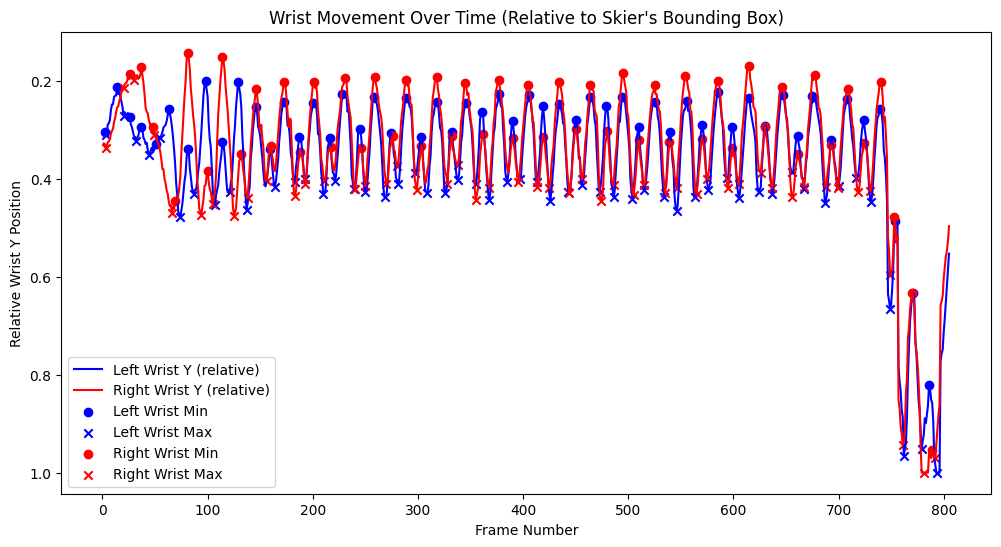

Extracting frame 2 from video...


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import cv2
from pathlib import Path

# Use your existing paths
ANNO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations\DJI_0038_annotations.json")
VIDEO_PATH = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0038.MP4")

# Load the JSON file
with open(ANNO_PATH, "r") as f:
    data = json.load(f)

# Extract wrist indices from keypoints list
keypoints_list = data["categories"][0]["keypoints"]
LWrist_index = keypoints_list.index("LWrist") * 3  # Multiply by 3 because (x, y, confidence)
RWrist_index = keypoints_list.index("RWrist") * 3

# Extract wrist positions and bounding boxes over time
frames = []
left_wrist_y = []
right_wrist_y = []

# Extract keypoints and bounding boxes from annotations
for annotation in data.get("annotations", []):
    frame_id = annotation["image_id"]
    keypoints = annotation["keypoints"]
    bbox = annotation["bbox"]  # Bounding box: [x, y, width, height]

    # Get Y-coordinates of the wrists
    lwrist_y = keypoints[LWrist_index + 1]  # Y-coordinate
    rwrist_y = keypoints[RWrist_index + 1]

    # Normalize Y positions relative to bounding box height
    bbox_height = bbox[3]
    lwrist_y_rel = (lwrist_y - bbox[1]) / bbox_height  # Normalize Y relative to bbox
    rwrist_y_rel = (rwrist_y - bbox[1]) / bbox_height

    frames.append(frame_id)
    left_wrist_y.append(lwrist_y_rel)
    right_wrist_y.append(rwrist_y_rel)

# Convert to numpy arrays for processing
frames = np.array(frames)
left_wrist_y = np.array(left_wrist_y)
right_wrist_y = np.array(right_wrist_y)

# Find local minima (lowest wrist positions) and maxima (highest wrist positions)
min_peaks_L, _ = find_peaks(-left_wrist_y, distance=10)  # Inverting for minima
max_peaks_L, _ = find_peaks(left_wrist_y, distance=10)
min_peaks_R, _ = find_peaks(-right_wrist_y, distance=10)
max_peaks_R, _ = find_peaks(right_wrist_y, distance=10)

# Plot wrist movement over time (relative to bounding box)
plt.figure(figsize=(12, 6))
plt.plot(frames, left_wrist_y, label="Left Wrist Y (relative)", color="blue")
plt.plot(frames, right_wrist_y, label="Right Wrist Y (relative)", color="red")
plt.scatter(frames[min_peaks_L], left_wrist_y[min_peaks_L], color="blue", marker="o", label="Left Wrist Min")
plt.scatter(frames[max_peaks_L], left_wrist_y[max_peaks_L], color="blue", marker="x", label="Left Wrist Max")
plt.scatter(frames[min_peaks_R], right_wrist_y[min_peaks_R], color="red", marker="o", label="Right Wrist Min")
plt.scatter(frames[max_peaks_R], right_wrist_y[max_peaks_R], color="red", marker="x", label="Right Wrist Max")
plt.xlabel("Frame Number")
plt.ylabel("Relative Wrist Y Position")
plt.legend()
plt.title("Wrist Movement Over Time (Relative to Skier's Bounding Box)")
plt.gca().invert_yaxis()  # Y-coordinates are flipped in images
plt.show()

# Get a frame number where a peak occurs for visualization
if len(min_peaks_L) > 0:
    peak_frame_id = frames[min_peaks_L[0]]
elif len(max_peaks_L) > 0:
    peak_frame_id = frames[max_peaks_L[0]]
else:
    peak_frame_id = frames[0]  # Default to first frame if no peaks found

print(f"Extracting frame {peak_frame_id} from video...")

# Open the video file
cap = cv2.VideoCapture(str(VIDEO_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
frame_time = peak_frame_id / fps  # Time at which to extract the frame

# Set video position and read the frame
cap.set(cv2.CAP_PROP_POS_FRAMES, peak_frame_id)
ret, frame = cap.read()
cap.release()

if ret:
    cv2.imshow("Detected Peak Frame", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Could not extract frame from video.")
